In [1]:
# importa os pacotes necessários
import numpy as np
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from scipy import stats as ss
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn import tree
import random
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [2]:
# carrega os dados
df = pd.read_csv('dados/BankChurners.csv',low_memory=False)

# head dos dados
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [3]:
# tamanho do dataset
df.shape

(10127, 23)

<AxesSubplot:ylabel='Attrition_Flag'>

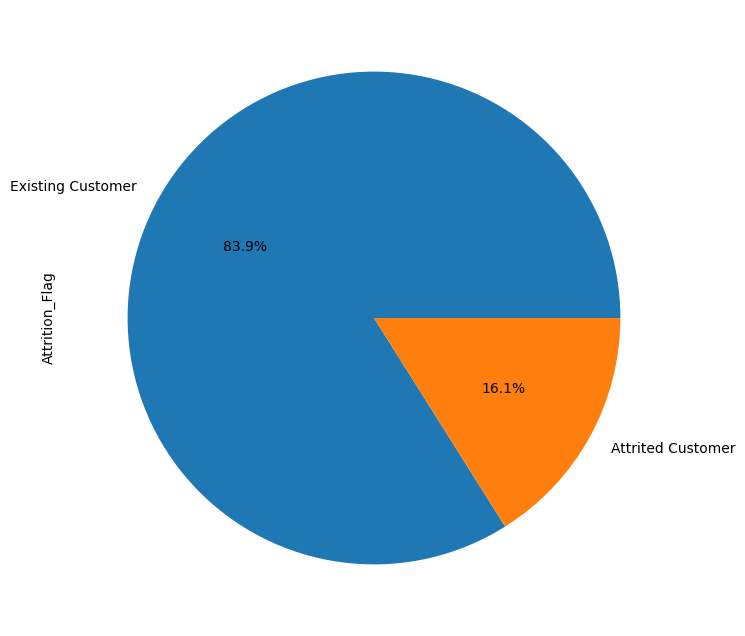

In [4]:
# distribuição da variável target
df.Attrition_Flag.value_counts().plot.pie(autopct='%1.1f%%',figsize=(10,8))

In [5]:
# remove as colunas que não vamos utilizar
df = df[df.columns[:-2]]

# cria coluna com flag de churn
df['Churn'] = df['Attrition_Flag'].apply(lambda x: 1 if x == 'Attrited Customer' else 0)

df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0


### 0. Definição de Funções

In [6]:
def plot_cm(y_true, y_pred, label, x_size=5, y_size=5, savepath=None):
    """
    Plots a confusion matrix

    Params:
        - y_true: the true value of the target
        - y_pred: the predicted value of the data
        - label: the name of the model
        - - x_size: x size of the plot
        - y_size: y size of the plot
        - savepath: the path to save the image
    """
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = "%.1f%%\n%d/%d" % (p, c, s)
            elif c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%\n%d" % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"
    fig, ax = plt.subplots(figsize=(x_size, y_size))
    plt.title("Matriz de Confusão - " + label, fontsize=15)
    sns.heatmap(cm, cmap="Blues", annot=annot, fmt="", ax=ax)
    # savesfig
    if savepath is not None:
        plt.savefig(savepath + ".png")
    plt.show()
    return cm


def class_def(multi, y_proba):
    "Helper function of the plot_roc_curve function"
    if multi is False:
        return [0]
    else:
        return range(len(y_proba[0]))


# função para plotar a curva ROC
def plot_roc_curve(
    y_true, y_proba, label, x_size=5, y_size=5, savepath=None, strategy="ovo"
):

    """
    Plots the roc auc curve.

    Params:
        - y_true: the true value of the target
        - y_proba: the predicted probability value of the data
        - label: the name of the model
        - - x_size: x size of the plot
        - y_size: y size of the plot
        - savepath: the path to save the image
    """

    # checks if it is multiclass
    if pd.Series(y_true).nunique() > 2:
        multi = True
    else:
        multi = False

    # creates no skill probas
    ns_probs = [0 for _ in range(len(y_true))]
    ns_true = [random.randint(0, 1) for _ in range(len(y_true))]
    ns_auc = roc_auc_score(ns_true, ns_probs)
    ns_fpr, ns_tpr, _ = roc_curve(ns_true, ns_probs)

    # keeps only the positive value if not multiclass
    if multi is False:
        try:
            y_proba = y_proba[:, 1]
        except Exception:
            y_proba = y_proba

    # calculates model ROC AUC SCORE
    if multi is True:
        model_auc = roc_auc_score(
            y_true, y_proba, multi_class=strategy, average="weighted"
        )
    else:
        model_auc = roc_auc_score(y_true, y_proba)

    fpr = {}
    tpr = {}
    thresh = {}
    n_class = class_def(multi, y_proba)
    if multi is True:
        for i in n_class:
            fpr[i], tpr[i], thresh[i] = roc_curve(
                y_true,
                y_proba[:, i],
                pos_label=i
                )
    else:
        for i in n_class:
            fpr[i], tpr[i], thresh[i] = roc_curve(y_true, y_proba)

    # summarize scores
    print("No Skill: ROC AUC=%.3f" % (ns_auc))
    print(label + ": ROC AUC=%.3f" % (model_auc))

    # plots the ROC Curve
    fig, ax = plt.subplots(figsize=(x_size, y_size))

    # define the colors
    colors_ls = ["b", "g", "r", "c", "m", "y", "k", "w"]
    colors = []
    cont = 0
    while len(colors) < len(n_class):
        if cont == len(colors_ls):
            cont = 0
        colors.append(colors_ls[cont])
        cont += 1

    # creates plots
    for i in n_class:
        plt.plot(
            fpr[i],
            tpr[i],
            linestyle="-",
            color=colors[i],
            label=f"Class {i+1}"
            )
    plt.plot(ns_fpr, ns_tpr, linestyle="--", label="No Skill")

    # axis labels
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    # plot title
    plt.title(f"ROC AUC Curve - {label}", fontsize=15)
    # show legend
    plt.legend(loc="best")
    # savesfig
    if savepath is not None:
        plt.savefig(savepath + ".png")
    # show the plot
    plt.show()


def tree_plot(modelo, X, x_size=5, y_size=5, savepath=None):
    """
    Plots the tree for tree based models.

    Params:
        - model: a sklearn trained model
        - X: the input data
        - x_size: x size of the plot
        - y_size: y size of the plot
        - savepath: the path to save the image
    """
    # tamanho do plot
    plt.figure(figsize=(x_size, y_size))

    # árvore criada
    tree.plot_tree(
        decision_tree=modelo,  # modelo criado
        feature_names=X.columns,  # lista de variáveis
        label="all",  # mostra os dados em todos os nós
        filled=True,  # pinta os nós com maior volumetria
        rounded=True,  # plota cada nó com pontas arredondadas
        fontsize=10,  # define o tamanho da fonte
    )

    # savesfig
    if savepath is not None:
        plt.savefig(savepath + ".png")

def clasifiers_test(
            X, Y, modelos, num_folds, metrica, x_size=5, y_size=5, savepath=None):
        """
        This function tests multiple clasifiers with cross validation
        and prints their scores.

        Params:
            - X: the input data
            - Y: the target data
            - num_folds: the number of folds to use
                in cross validation
            - x_size: x size of the plot
            - y_size: y size of the plot
            - savepath: the path to save the image
        """
        # Avaliando cada modelo em um loop
        resultados = []

        nomes = []

        print(f"MODELO\t|\t  MEDIA  \t|\tDESVIO")
        for nome, modelo in modelos:
            kfold = KFold(n_splits=num_folds)
            cv_results = cross_val_score(
                modelo,
                X,
                Y,
                cv=kfold,
                scoring=metrica
                )
            resultados.append(cv_results)
            nomes.append(nome)
            msg = "%s\t|\t%f\t|\t%f" % (
                nome,
                cv_results.mean(),
                cv_results.std()
                )
            print(msg)

        # Boxplot para comparar os algoritmos
        fig = plt.figure(figsize=(x_size, y_size))
        fig.suptitle("Comparação de Algoritmos de Classificação")
        ax = fig.add_subplot(111)
        plt.boxplot(resultados)
        ax.set_xticklabels(nomes)
        # savesfig
        if savepath is not None:
            plt.savefig(savepath + ".png")
        plt.show()
        return pd.DataFrame(
            resultados,
            columns=[f"fold_{i}" for i in range(num_folds)],
            index=nomes
        )

### 1. Definição de Variáveis

In [7]:
# tipos dos dados
df.dtypes

CLIENTNUM                     int64
Attrition_Flag               object
Customer_Age                  int64
Gender                       object
Dependent_count               int64
Education_Level              object
Marital_Status               object
Income_Category              object
Card_Category                object
Months_on_book                int64
Total_Relationship_Count      int64
Months_Inactive_12_mon        int64
Contacts_Count_12_mon         int64
Credit_Limit                float64
Total_Revolving_Bal           int64
Avg_Open_To_Buy             float64
Total_Amt_Chng_Q4_Q1        float64
Total_Trans_Amt               int64
Total_Trans_Ct                int64
Total_Ct_Chng_Q4_Q1         float64
Avg_Utilization_Ratio       float64
Churn                         int64
dtype: object

In [8]:
# variáveis contínuas
continuas = [
    'Customer_Age',
    'Dependent_count',
    'Months_on_book',
    'Total_Relationship_Count',
    'Months_Inactive_12_mon',
    'Contacts_Count_12_mon',
    'Credit_Limit',
    'Total_Revolving_Bal',
    'Avg_Open_To_Buy',
    'Total_Amt_Chng_Q4_Q1',
    'Total_Trans_Amt',
    'Total_Trans_Ct',
    'Total_Ct_Chng_Q4_Q1',
    'Avg_Utilization_Ratio'
]

# variáveis categóricas
categoricas = [
    'Gender',
    'Education_Level',
    'Marital_Status',
    'Income_Category',
    'Card_Category'
]

# resposta
resposta = ['Churn']

### 2. Análise Exploratória

#### 2.1 Variáveis Contínuas

In [9]:
df[continuas].describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


array([<AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>,
       <AxesSubplot:ylabel='Density'>, <AxesSubplot:ylabel='Density'>],
      dtype=object)

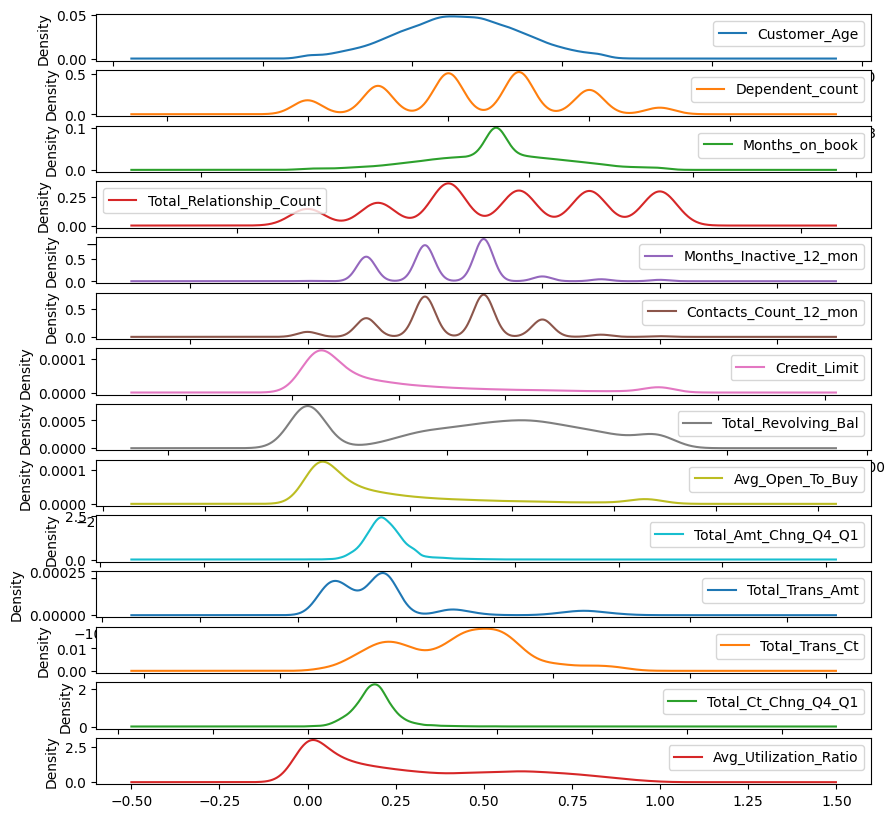

In [10]:
# faz um plot de densidade das variávels contínuas
df[continuas].plot(
    kind="density",
    subplots=True,
    sharex=False,
    figsize=(10, 10)
    )

Podemos ver que as variáveis contínuas não seguem uma distribuição normal e por isso devemos tomar alguns cuidados na hora de testar uma Regressão Logística por exemplo por ser uma técnica que tem como premissa que as variáveis explicativas seguem uma distribuição normal, o correto seria padronizar os dados antes do treinamento para que a média seja 0 e o desvio padrão 1.

Customer_Age                   AxesSubplot(0.125,0.11;0.0466867x0.77)
Dependent_count             AxesSubplot(0.181024,0.11;0.0466867x0.77)
Months_on_book              AxesSubplot(0.237048,0.11;0.0466867x0.77)
Total_Relationship_Count    AxesSubplot(0.293072,0.11;0.0466867x0.77)
Months_Inactive_12_mon      AxesSubplot(0.349096,0.11;0.0466867x0.77)
Contacts_Count_12_mon        AxesSubplot(0.40512,0.11;0.0466867x0.77)
Credit_Limit                AxesSubplot(0.461145,0.11;0.0466867x0.77)
Total_Revolving_Bal         AxesSubplot(0.517169,0.11;0.0466867x0.77)
Avg_Open_To_Buy             AxesSubplot(0.573193,0.11;0.0466867x0.77)
Total_Amt_Chng_Q4_Q1        AxesSubplot(0.629217,0.11;0.0466867x0.77)
Total_Trans_Amt             AxesSubplot(0.685241,0.11;0.0466867x0.77)
Total_Trans_Ct              AxesSubplot(0.741265,0.11;0.0466867x0.77)
Total_Ct_Chng_Q4_Q1         AxesSubplot(0.797289,0.11;0.0466867x0.77)
Avg_Utilization_Ratio       AxesSubplot(0.853313,0.11;0.0466867x0.77)
dtype: object

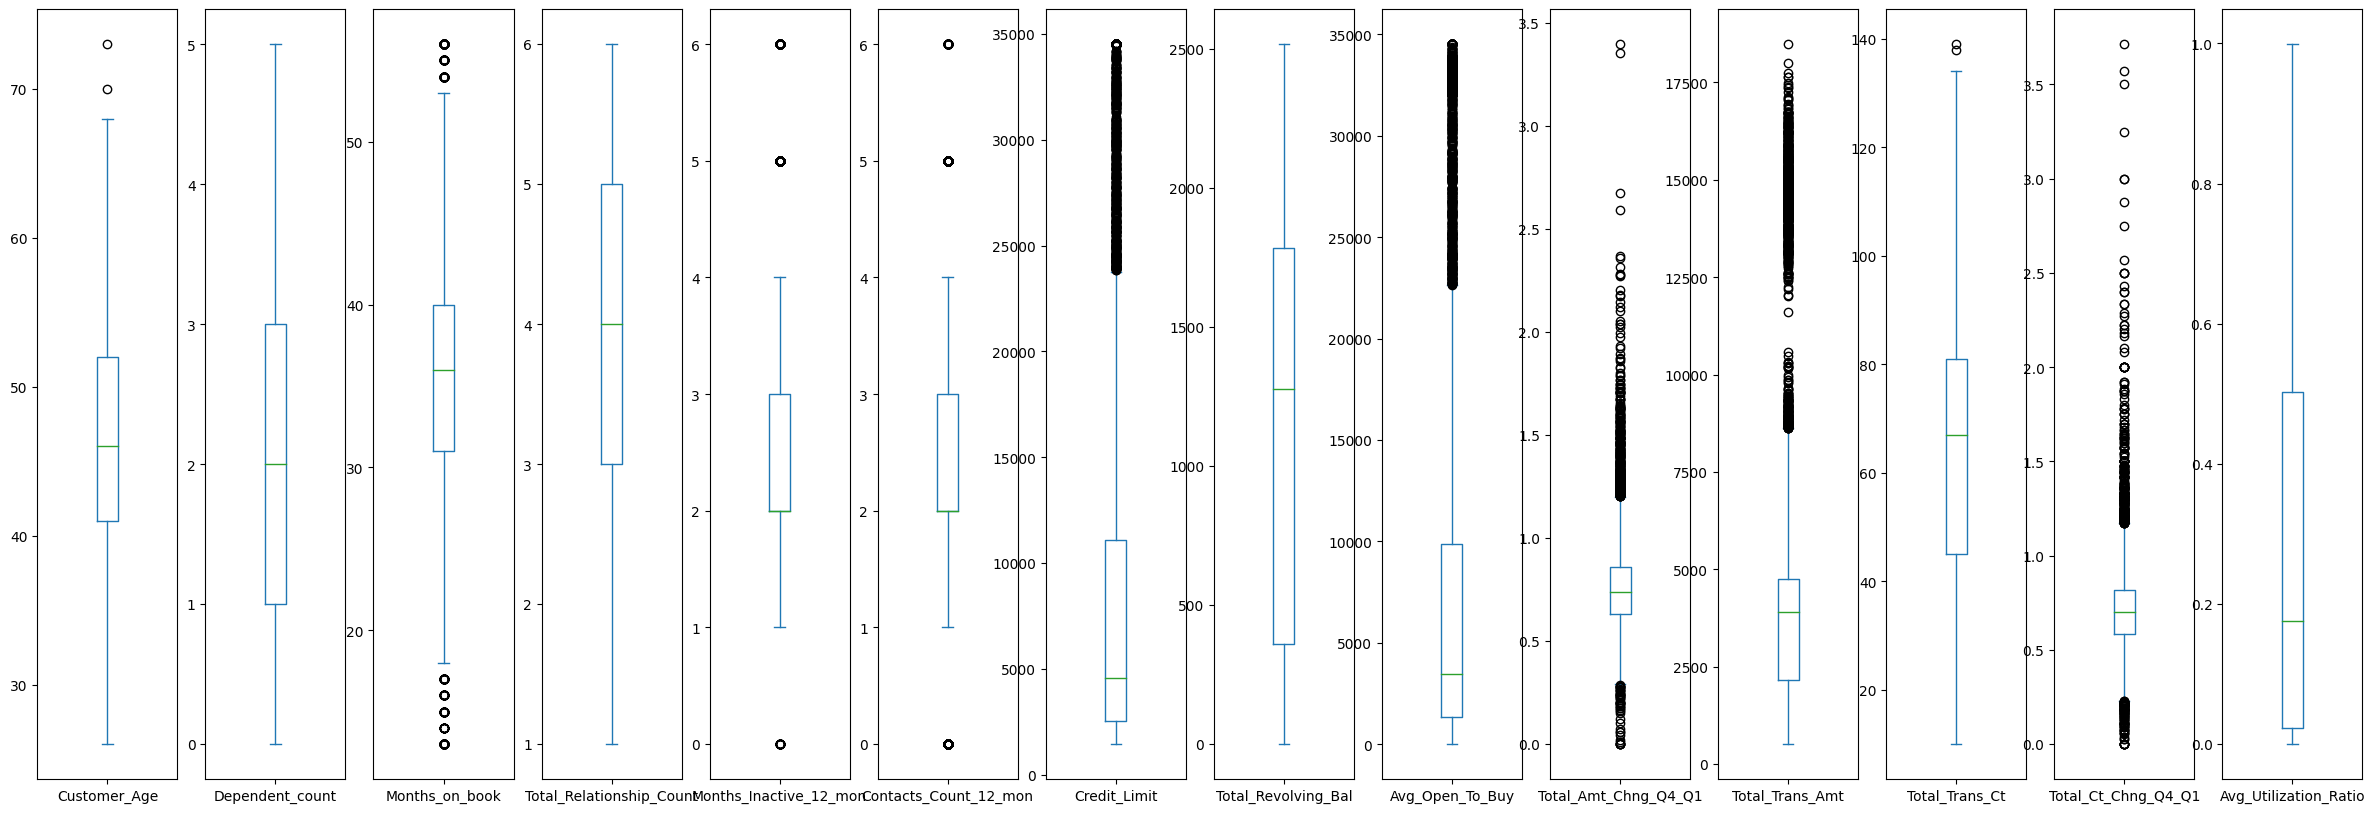

In [11]:
df[continuas].plot(
        kind="box",
        subplots=True,
        sharex=False,
        figsize=(30, 10)
    )

Podemos agora verificar que algumas das nossas variáveis têm muitos outliers, por isso, é necessário realizar uma padronização antes de utilizarmos um algoritmo que calcula distâncias como o KNN, por exemplo.

In [12]:
df[continuas + resposta].head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Churn
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0


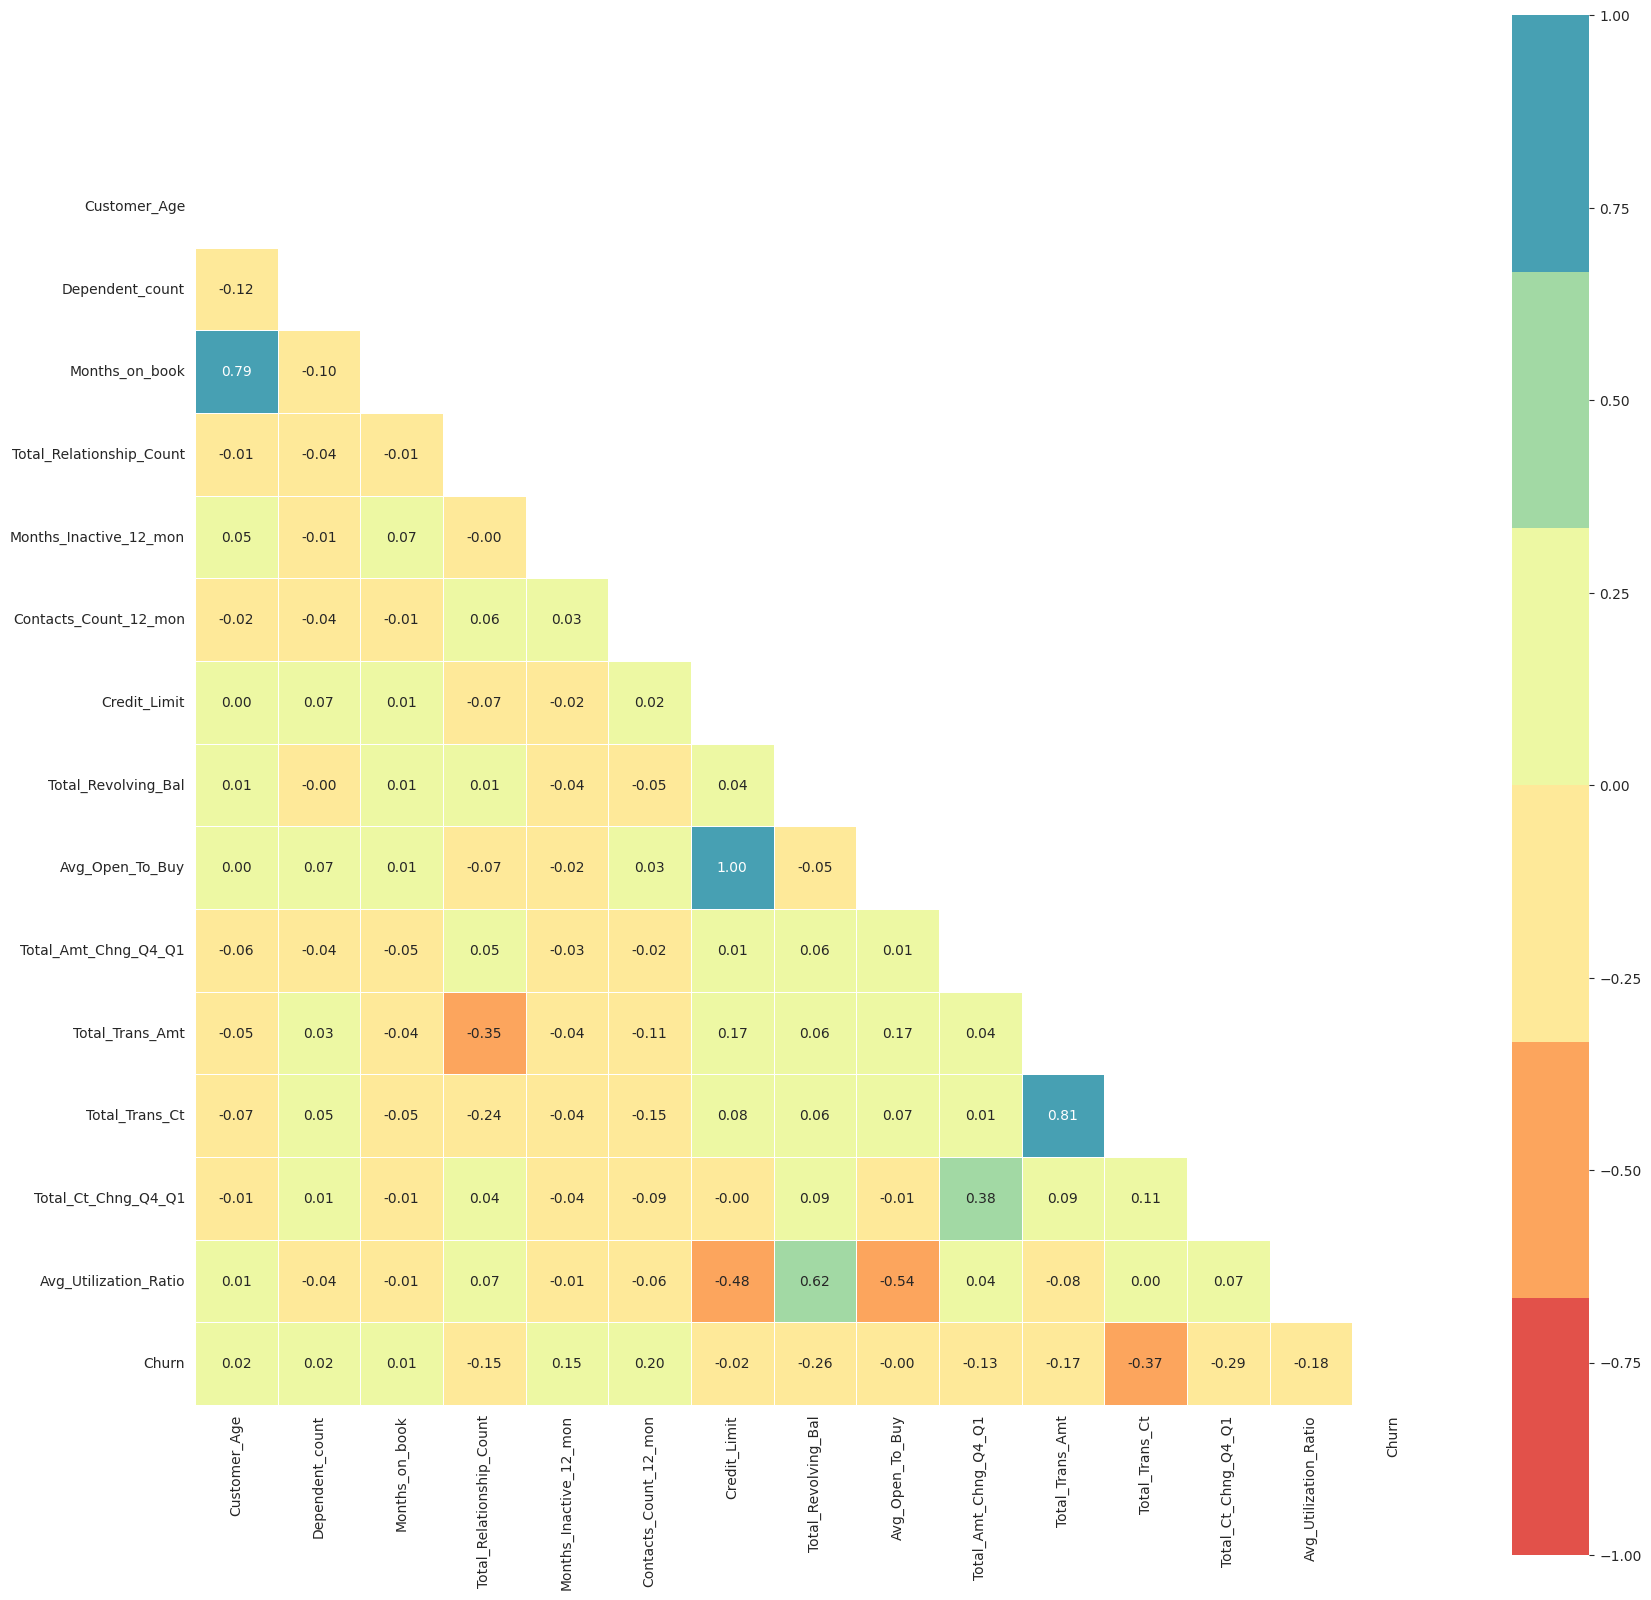

In [13]:
# cria matriz de correlação
correlations = df[continuas + resposta].corr()

# cria figura
fig = plt.figure(figsize=(20, 20))

# cria a máscara
mask = np.zeros_like(correlations, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# cria eixos
with sns.axes_style("white"):
    sns.heatmap(
        correlations,
        mask=mask,
        vmin=-1,
        vmax=1,
        square=True,
        annot=True,
        fmt=".2f",
        linewidths=0.5,
        cmap=sns.color_palette("Spectral"),
    )

Podemos ver pelo gráfico acima que algumas variáveis tem uma correlação muito alta entre elas, como por exemplo as variáveis Credit_Limit e Avg_Open_To_Buy que tem uma correlação perfeita e igual a 1.

#### 2.2 Variáveis Categóricas

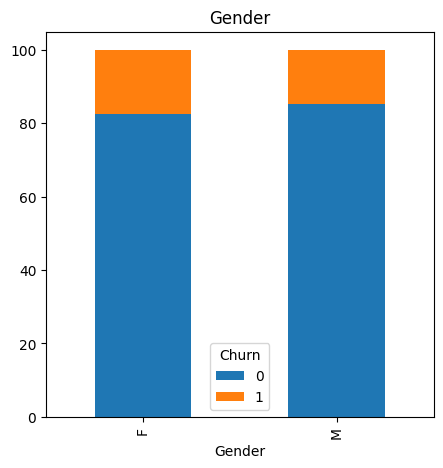

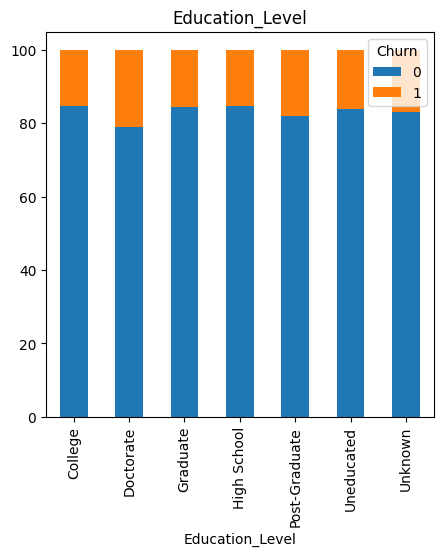

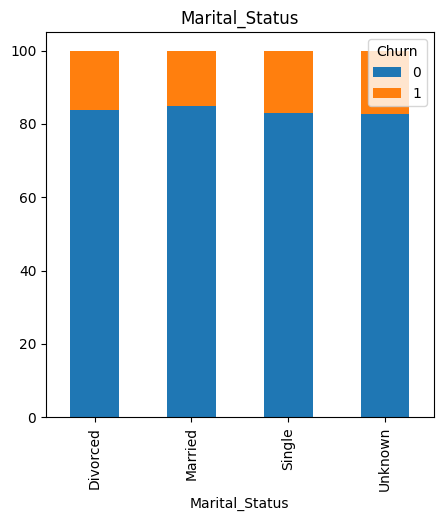

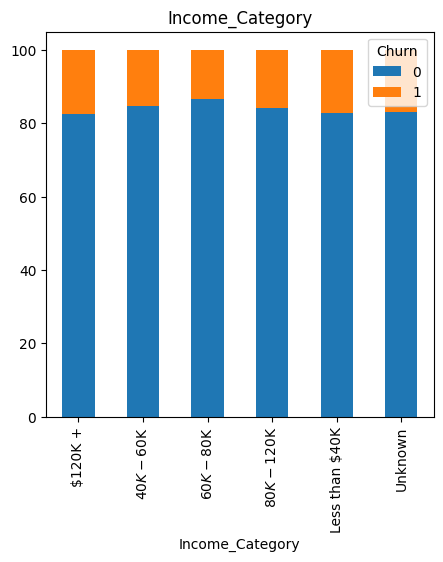

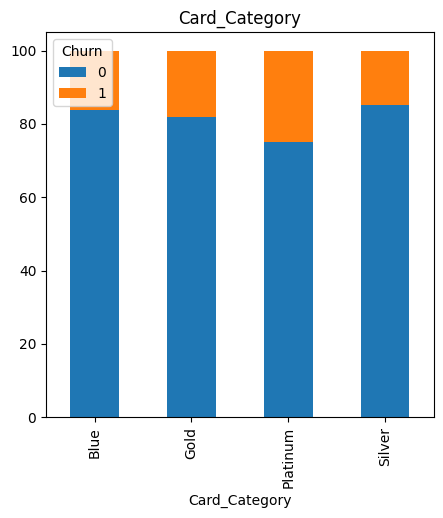

In [22]:
# gráfico de distribuição das variáveis categoricas
for col in categoricas:
    df.groupby([col, 'Churn']).size().groupby(level=0).apply(lambda x: 100 * x / x.sum()).unstack().plot(
        kind='bar',
        stacked=True,
        figsize=(5,5),
        title=col
    )

Podemos perceber que a Categoria do Cartão de Crédito, a Categoria de Renda e o Nível Educacional são as variáveis que mais distorcem a distribuição de churn.

### 3. Preparação dos Dados

#### 3.1 Modelagem sem DataPrep

MODELO	|	  MEDIA  	|	DESVIO
LR	|	0.925363	|	0.030939
NB	|	0.911319	|	0.077415
KNN	|	0.789379	|	0.127392
CART	|	0.783243	|	0.097311
RF	|	0.931581	|	0.080922
SVM	|	0.788935	|	0.109081
GB	|	0.959501	|	0.035726


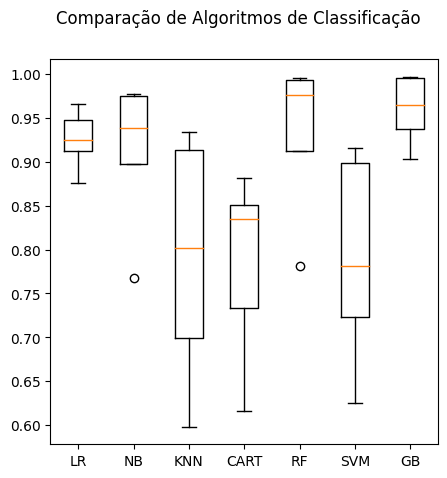

,fold_0,fold_1,fold_2,fold_3,fold_4
LR,0.912041,0.925528,0.965599,0.948038,0.875609
NB,0.897145,0.938477,0.975561,0.977389,0.768020
KNN,0.699394,0.802362,0.913392,0.933792,0.597955
CART,0.732909,0.835435,0.881197,0.850627,0.616049
RF,0.912195,0.975918,0.995290,0.993108,0.781395
SVM,0.723526,0.780913,0.898797,0.916352,0.625086
GB,0.937779,0.964392,0.997111,0.995239,0.902982


In [23]:
# separa variáveis preditoras e variável resposta
X = df[categoricas + continuas]
Y = df["Churn"]

# cria os dummies
X = pd.get_dummies(X, drop_first=True)

# cria uma lista de modelos para testar
modelos = []
modelos.append(("LR", LogisticRegression(max_iter=5000)))
modelos.append(("NB", GaussianNB()))
modelos.append(("KNN", KNeighborsClassifier()))
modelos.append(("CART", DecisionTreeClassifier()))
modelos.append(("RF", RandomForestClassifier()))
modelos.append(("SVM", SVC()))
modelos.append(("GB", GradientBoostingClassifier()))

# testa os modelos
clasifiers_test(X=X, Y=Y, modelos = modelos, num_folds=5, metrica="roc_auc")

Neste primeiro teste podemos verificar que os algoritmos Gradient Boosting, Random Forest, Naive Bayes e Regressão Logísitica tiveram melhor performance e também foram mais estáveis tendo um desvio padrão mais baixo.

#### 3.2 Modelagem com DataPrep

In [24]:
# cria uam cópia do df para o pré-processamento
df_pre = df.copy()

In [25]:
# cria a correlação
correlacao = df[continuas + resposta].corr()

# lista de pares de variáveis correlacionadas
pares = []

# loop para encontrar as variáveis correlacionadas
for index,row in correlacao.iterrows():
    for col in correlacao.columns:
        # se o valor absoluto for maior que 0.7 e não for a mesma variável appenda o par de variáveis
        if index != col and index != resposta[0] and col != resposta[0] and abs(correlacao.loc[index,col]) > 0.7:
            pares.append((index,col))

# lista de variáveis a serem excluídas
excluir = []

# loop para encontrar as variáveis a serem excluídas
for col1,col2 in pares:
    # se o valor absoluto da correlação da variável com a resposta for maior que o 
    # valor absoluto da correlação da outra variável com a resposta
    # então appenda a variável com menor correlação
    if abs(correlacao.loc[col1,'Churn']) >= abs(correlacao.loc[col2,'Churn']):
        excluir.append(col2)
    else:
        excluir.append(col1)
print(f'Variáveis para excluir por alta correlação: {excluir}')

Variáveis para excluir por alta correlação: ['Months_on_book', 'Months_on_book', 'Avg_Open_To_Buy', 'Avg_Open_To_Buy', 'Total_Trans_Amt', 'Total_Trans_Amt']


In [26]:
# definição do skew maximo
skew_max = 0.5

# calculo do skew da variáveis contínuas
continuas_finais = [col for col in continuas if col not in excluir]
skew = df_pre[continuas_finais].skew()

# cria lista com variáveis que precisam de transformação
skew = skew[abs(skew) > skew_max]
skew = skew.index.tolist()
print(skew)

['Months_Inactive_12_mon', 'Credit_Limit', 'Total_Amt_Chng_Q4_Q1', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio']


In [27]:
# agora vamos normalizar as variáveis para que tenham média 0 e desvio padrão 1
scaler = StandardScaler()
df_pre[skew] = scaler.fit_transform(df_pre[skew])

MODELO	|	  MEDIA  	|	DESVIO
LR	|	0.930955	|	0.042291
NB	|	0.894400	|	0.081236
KNN	|	0.790691	|	0.123536
CART	|	0.779691	|	0.097514
RF	|	0.931070	|	0.082549
SVM	|	0.787652	|	0.126277
GB	|	0.959513	|	0.035728


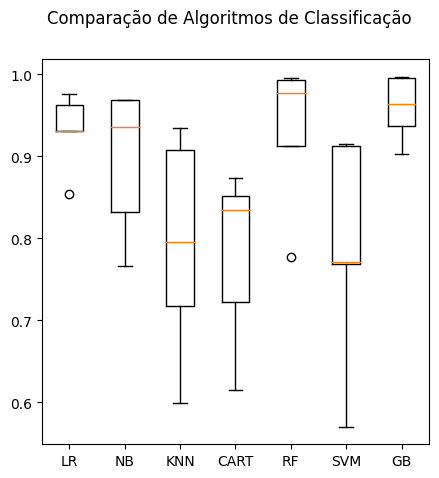

,fold_0,fold_1,fold_2,fold_3,fold_4
LR,0.930951,0.931205,0.975852,0.962734,0.854034
NB,0.832342,0.935686,0.968715,0.968831,0.766424
KNN,0.717083,0.794983,0.907770,0.934173,0.599444
CART,0.722932,0.835211,0.874142,0.851353,0.614815
RF,0.912623,0.977632,0.995272,0.992572,0.777254
SVM,0.769101,0.771369,0.912335,0.915264,0.570192
GB,0.937670,0.964423,0.997111,0.995300,0.903060


In [28]:
# separa variáveis preditoras e variável resposta
X = df_pre[categoricas + continuas]
Y = df_pre["Churn"]

# cria os dummies
X = pd.get_dummies(X, drop_first=True)

# cria uma lista de modelos para testar
modelos = []
modelos.append(("LR", LogisticRegression(max_iter=5000)))
modelos.append(("NB", GaussianNB()))
modelos.append(("KNN", KNeighborsClassifier()))
modelos.append(("CART", DecisionTreeClassifier()))
modelos.append(("RF", RandomForestClassifier()))
modelos.append(("SVM", SVC()))
modelos.append(("GB", GradientBoostingClassifier()))

# testa os modelos
clasifiers_test(X=X, Y=Y, modelos = modelos, num_folds=5, metrica="roc_auc")

Neste segundo teste podemos verificar que os algoritmos que tiveram boa performance no teste anterior continuaram tendo boa performance. As diferenças de fato estão na Regressão Logística e no Naive Bayes, no caso da regressão mesmo utilizando menos variáveis preditoras vemos que teve uma pequena melhora pois no segundo dataset criado as variáveis seguem as premissas do algoritmo, já no caso do Naive Bayes mesmo seguindo as premissas necessárias acabou perdendo um pouco de performance.

Outro ponto interessante é que os demais modelos mantiveram seus resultados mesmo descartando 4 variáveis, mostrando que remover variáveis não necessariamente diminui a performance do modelo.

### 4. Modelagem

#### 4.1 Baseline

Como modelo base neste case vamos utilizar a Regressão Logística por ter alta performance e ser o modelo linear e o Gradient Boosting por ter atingido a mais alta performance dos modelos testados

In [29]:
# separa variáveis preditoras e variável resposta
X = df_pre[categoricas + continuas]
Y = df_pre["Churn"]

# cria os dummies
X = pd.get_dummies(X, drop_first=True)

# separa os dados entre treino e teste
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=7)

In [30]:
# cria o modelo baseline de regressão logística
modelo_rl = LogisticRegression(max_iter=5000)

# treina o modelo
modelo_rl.fit(X_train, Y_train)

# faz as previsões com dados de teste
Y_pred = modelo_rl.predict(X_test)
Y_pred_proba = modelo_rl.predict_proba(X_test)[:, 1]

# faz as previsões com dados de treino
Y_pred_train = modelo_rl.predict(X_train)
Y_pred_proba_train = modelo_rl.predict_proba(X_train)[:, 1]

<AxesSubplot:xlabel='Variavel'>

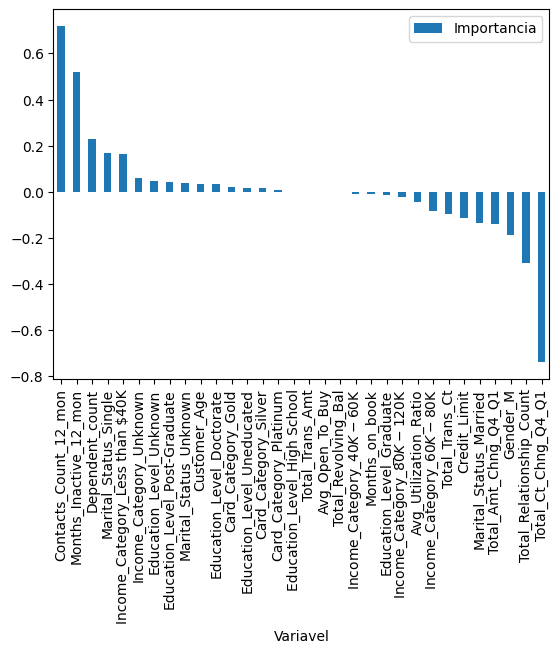

In [31]:
# mostra a importância das variáveis
importancia = pd.DataFrame({"Variavel": X_train.columns, "Importancia": modelo_rl.coef_[0]})
importancia.sort_values("Importancia", ascending=False).plot.bar(x="Variavel", y="Importancia")

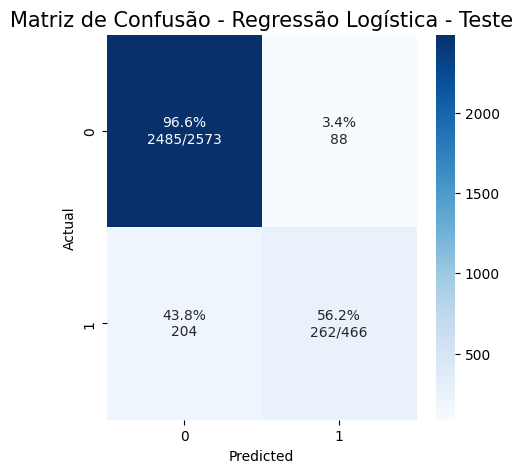

Predicted,0,1
Actual,,
0,2485,88
1,204,262


In [32]:
# plota a matriz de confusão de teste
plot_cm(Y_test, Y_pred, 'Regressão Logística - Teste')

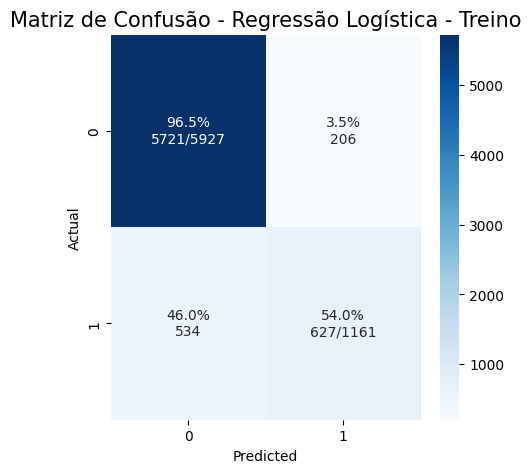

Predicted,0,1
Actual,,
0,5721,206
1,534,627


In [33]:
# plota a matriz de confusão de treino 
plot_cm(Y_train, Y_pred_train, 'Regressão Logística - Treino')

Podemos perceber que a matriz de confusão ficou com uma acurácia baixa neste modelo porém isso se deve ao fato de termos uma resposta com dados desbalanceados. Para melhor avaliarmos o modelo precisamos plotar a curva roc.

No Skill: ROC AUC=0.500
Regressão Logística - Teste: ROC AUC=0.920


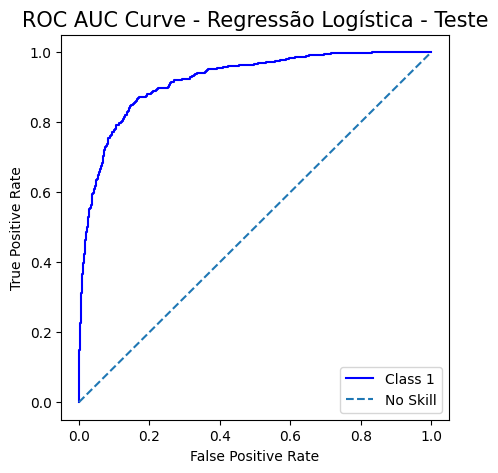

In [34]:
# plota a curva ROC de teste
plot_roc_curve(Y_test, Y_pred_proba, 'Regressão Logística - Teste')

No Skill: ROC AUC=0.500
Regressão Logística - Treino: ROC AUC=0.918


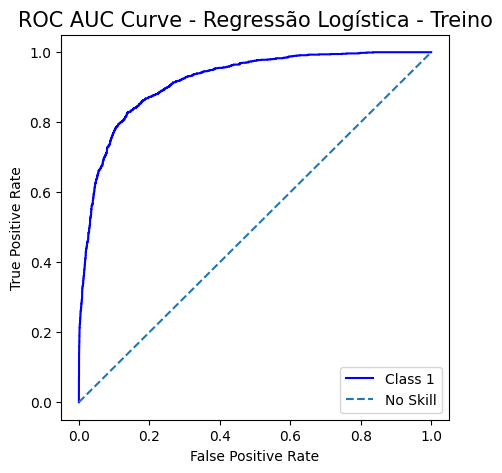

In [35]:
# plota a curva ROC de treino
plot_roc_curve(Y_train, Y_pred_proba_train, 'Regressão Logística - Treino')

ROC é uma curva de probabilidade e AUC representa o grau ou medida de separabilidade. Diz o quanto o modelo é capaz de distinguir entre as classes. Quanto maior a AUC, melhor será o modelo.

Aqui atingimos 0.918 em treino e 0.920 em teste, resultados bastante parecidos, o que nos indica que não houve overfitting e por ser um resultado bom também não houve underfitting.

<AxesSubplot:xlabel='Churn_Prob', ylabel='Count'>

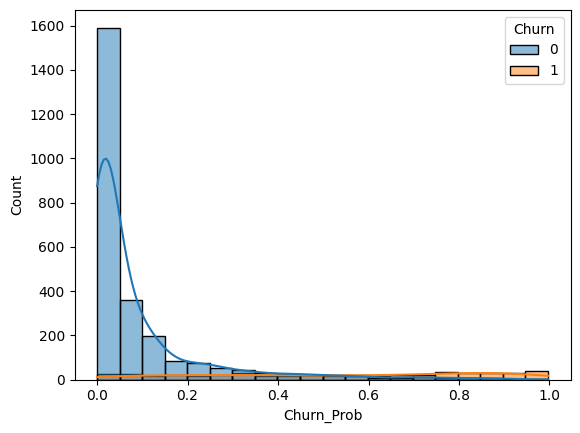

In [36]:
# plota um histograma com as probabilidades de churn
df_result = pd.DataFrame({'Churn':Y_test, 'Churn_Prob':Y_pred_proba})
sns.histplot(data=df_result,x = 'Churn_Prob',hue='Churn', bins=20, kde=True)

<AxesSubplot:xlabel='Churn_Prob', ylabel='Count'>

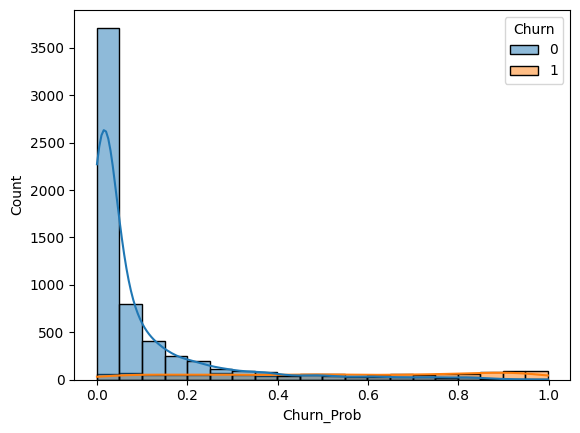

In [37]:
# plota um histograma com as probabilidades de churn
df_result = pd.DataFrame({'Churn':Y_train, 'Churn_Prob':Y_pred_proba_train})
sns.histplot(data=df_result,x = 'Churn_Prob',hue='Churn', bins=20, kde=True)

Pelos histogramas acima podemos ver que a classe 1 ainda não está tão separada da classe 0 quanto pretendemos

In [38]:
# cria o modelo baseline de gradient boosting
modelo_gb = GradientBoostingClassifier()

# treina o modelo
modelo_gb.fit(X_train, Y_train)

# faz as previsões com dados de teste
Y_pred = modelo_gb.predict(X_test)
Y_pred_proba = modelo_gb.predict_proba(X_test)[:, 1]

# faz as previsões com dados de treino
Y_pred_train = modelo_gb.predict(X_train)
Y_pred_proba_train = modelo_gb.predict_proba(X_train)[:, 1]

<AxesSubplot:xlabel='Variavel'>

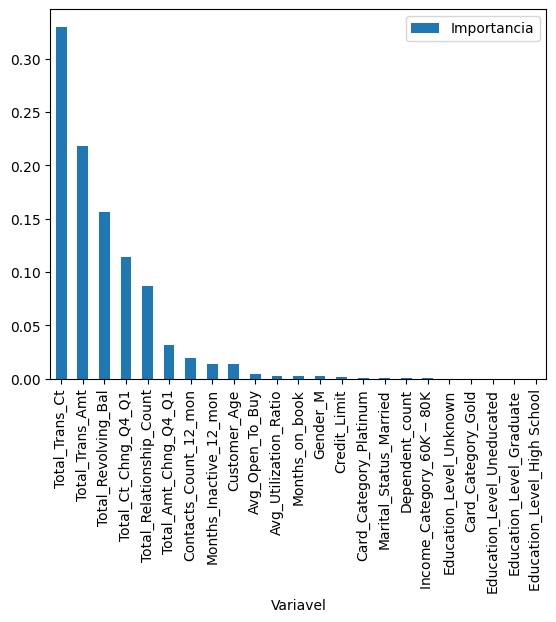

In [39]:
# mostra a importância das variáveis
importancia = pd.DataFrame({"Variavel": X_train.columns, "Importancia": modelo_gb.feature_importances_})
importancia.query("Importancia > 0").sort_values("Importancia", ascending=False).plot.bar(x="Variavel", y="Importancia")

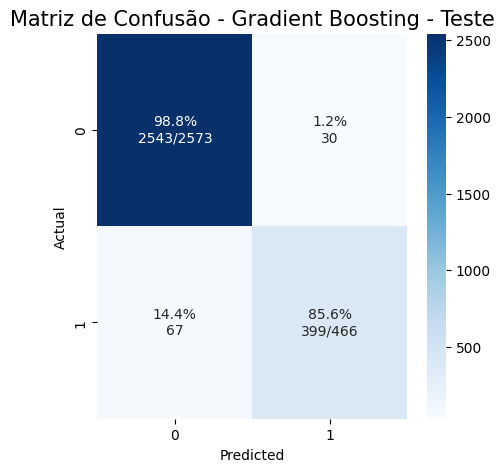

Predicted,0,1
Actual,,
0,2543,30
1,67,399


In [40]:
# plota a matriz de confusão de teste
plot_cm(Y_test, Y_pred, 'Gradient Boosting - Teste')

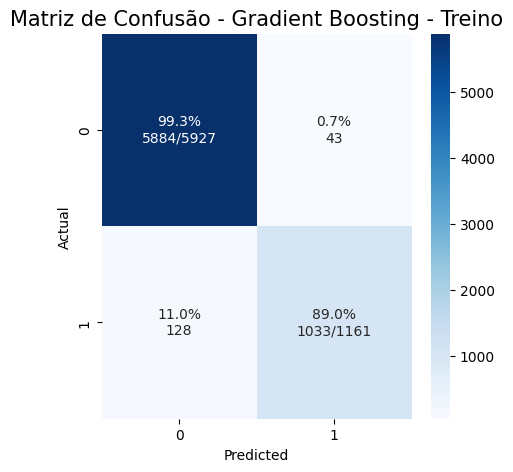

Predicted,0,1
Actual,,
0,5884,43
1,128,1033


In [41]:
# plota a matriz de confusão de treino
plot_cm(Y_train, Y_pred_train, 'Gradient Boosting - Treino')

Aqui podemos perceber que o Gradient Boosting conseguiu resolver relativamente bem o desbalanceamento da base acertando 89% dos clientes com churn.

No Skill: ROC AUC=0.500
Gradient Boosting - Teste: ROC AUC=0.988


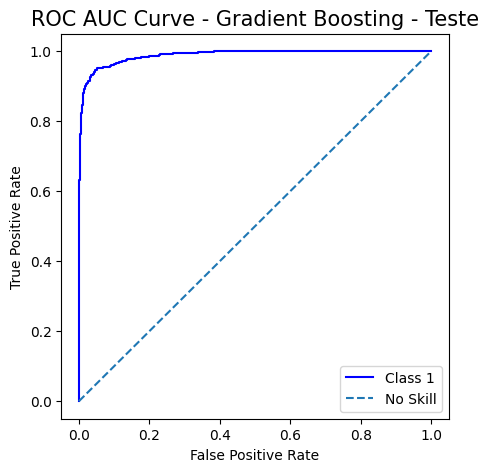

In [42]:
# plota a curva ROC de teste
plot_roc_curve(Y_test, Y_pred_proba, 'Gradient Boosting - Teste')

No Skill: ROC AUC=0.500
Gradient Boosting - Treino: ROC AUC=0.996


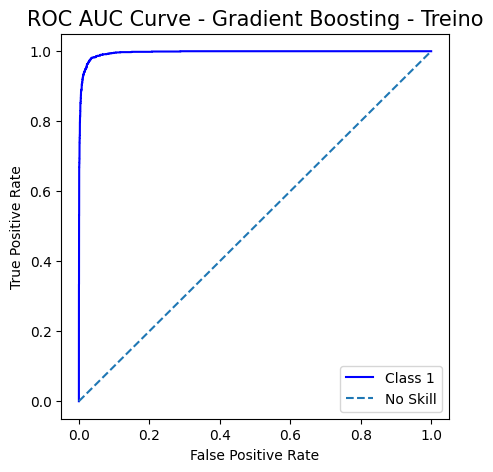

In [43]:
# plota a curva ROC de teste
plot_roc_curve(Y_train, Y_pred_proba_train, 'Gradient Boosting - Treino')

Com o Gradient Boosting podemos visualizar que o algoritmo ficou com uma ROC AUC Score bem próximo do perfeito nos resultados de treino e acabou descolando um pouco dos dados de teste, indicando um leve overfitting no mesmo.

<AxesSubplot:xlabel='Churn_Prob', ylabel='Count'>

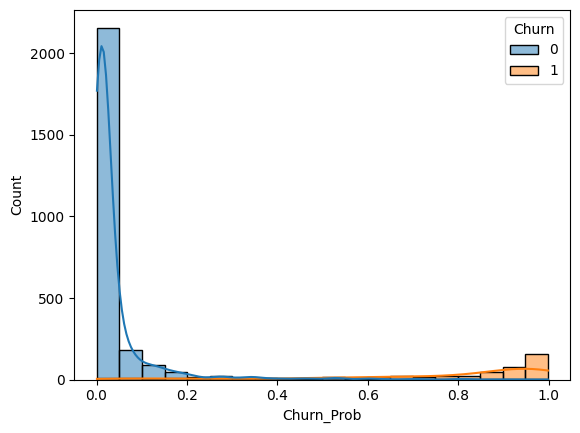

In [44]:
# plota um histograma com as probabilidades de churn
df_result = pd.DataFrame({'Churn':Y_test, 'Churn_Prob':Y_pred_proba})
sns.histplot(data=df_result,x = 'Churn_Prob',hue='Churn', bins=20, kde=True)

<AxesSubplot:xlabel='Churn_Prob', ylabel='Count'>

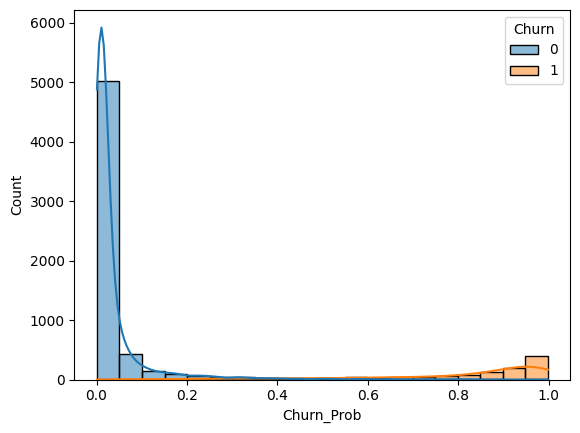

In [45]:
# plota um histograma com as probabilidades de churn
df_result = pd.DataFrame({'Churn':Y_train, 'Churn_Prob':Y_pred_proba_train})
sns.histplot(data=df_result,x = 'Churn_Prob',hue='Churn', bins=20, kde=True)

Nestes histogramas já podemos perceber que há uma clara diferença entre as classes indicando que o modelo consegue separar ambas muito bem.

#### 4.1.1 Ajustando Hiperparâmetros

Nos modelos baseline não ajustamos nenhum hiperparâmetro e podemos melhorar os nossos resultados encontrando o melhor conjunto para cada modelo.

Neste teste vamos alterar os principais hiperparâmetros de cada algoritmo:

- Regressão Logística:
    - Penalty: podemos a penalização de variáveis para melhor ajustar os coeficientes do modelo
    - C: inverso da força de penalização


- Gradient Boosting:
    - learning_rate: taxa de aprendizado do modelo
    - n_estimators: número de árvores de regressão utilizadas pelo modelo
    - min_samples_leaf: quantidade mínima de dados em uma folha
    - max_depth: profundidade máxima das árvores

##### 4.1.1 Gradient Boosting

In [46]:
# define os hiperparametros
parametros = {
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 200, 300],
        'min_samples_leaf': [0.05,0.1,0.2],
        'max_depth': [3, 5, 7, 9],
        }

# parametros = {
#         'learning_rate': [0.05, 0.1],
#         'n_estimators': [100],
#         'min_samples_leaf': [0.1,0.2],
#         'max_depth': [ 7, 9],
#         }


# define o modelo
modelo_gb = GradientBoostingClassifier()

# define a estratégia de busca
grid_gb = GridSearchCV(modelo_gb, parametros, cv=5, scoring='roc_auc', n_jobs=-1)

# treina o modelo
grid_gb.fit(X_train, Y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7, 9],
                         'min_samples_leaf': [0.05, 0.1, 0.2],
                         'n_estimators': [100, 200, 300]},
             scoring='roc_auc')

In [47]:
# imprime os melhores parâmetros
print(f'Os melhores parâmetros encontrados foram: {grid_gb.best_params_}')

# coloca os resultados em um dataframe
resultados = pd.DataFrame(grid_gb.cv_results_)
resultados = resultados.sort_values('mean_test_score', ascending=False)
resultados.head()

Os melhores parâmetros encontrados foram: {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 0.05, 'n_estimators': 300}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_leaf,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
83,12.047449,0.524450,0.022624,0.006087,0.1,5,0.05,300,"{'learning_rate': 0.1, 'max_depth': 5, 'min_sa...",0.993371,0.992001,0.993043,0.991619,0.987993,0.991605,0.001918,1
100,10.500604,0.760915,0.019788,0.001503,0.1,9,0.05,200,"{'learning_rate': 0.1, 'max_depth': 9, 'min_sa...",0.993360,0.991626,0.993155,0.991081,0.988608,0.991566,0.001717,2
101,16.559661,1.097124,0.026604,0.002108,0.1,9,0.05,300,"{'learning_rate': 0.1, 'max_depth': 9, 'min_sa...",0.992938,0.991910,0.993104,0.991445,0.988313,0.991542,0.001730,3
91,9.502735,0.448573,0.017071,0.000798,0.1,7,0.05,200,"{'learning_rate': 0.1, 'max_depth': 7, 'min_sa...",0.992768,0.991859,0.992756,0.991110,0.988386,0.991376,0.001618,4
92,14.643340,0.912256,0.025908,0.003178,0.1,7,0.05,300,"{'learning_rate': 0.1, 'max_depth': 7, 'min_sa...",0.992539,0.991979,0.992934,0.991150,0.987927,0.991306,0.001792,5


In [48]:
# treina o modelo com os melhores parâmetros
modelo_gb = GradientBoostingClassifier(
    learning_rate=grid_gb.best_params_['learning_rate'],
    max_depth=grid_gb.best_params_['max_depth'],
    min_samples_leaf=grid_gb.best_params_['min_samples_leaf'],
    n_estimators=grid_gb.best_params_['n_estimators']
)

# treina o modelo
modelo_gb.fit(X_train, Y_train)

# faz as previsões com dados de teste
Y_pred = modelo_gb.predict(X_test)
Y_pred_proba = modelo_gb.predict_proba(X_test)[:, 1]

# faz as previsões com dados de treino
Y_pred_train = modelo_gb.predict(X_train)
Y_pred_proba_train = modelo_gb.predict_proba(X_train)[:, 1]

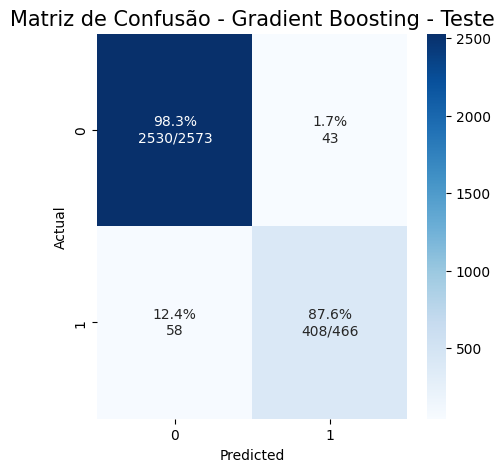

Predicted,0,1
Actual,,
0,2530,43
1,58,408


In [49]:
# plota a matriz de confusão de teste
plot_cm(Y_test, Y_pred, 'Gradient Boosting - Teste')

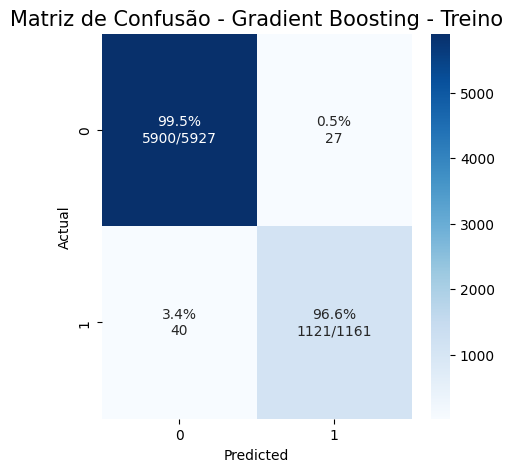

Predicted,0,1
Actual,,
0,5900,27
1,40,1121


In [50]:
# plota a matriz de confusão de treino
plot_cm(Y_train, Y_pred_train, 'Gradient Boosting - Treino')

No Skill: ROC AUC=0.500
Gradient Boosting - Teste: ROC AUC=0.990


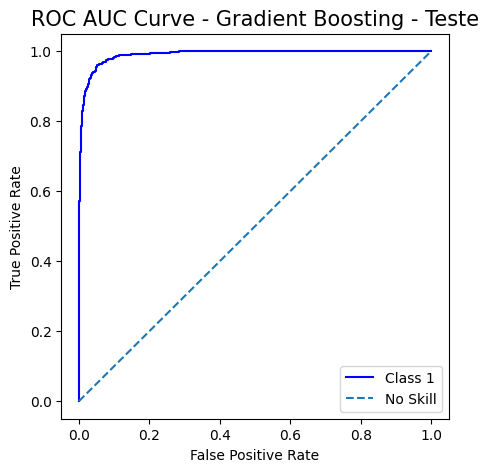

In [51]:
# plota a curva ROC de teste
plot_roc_curve(Y_test, Y_pred_proba, 'Gradient Boosting - Teste')

No Skill: ROC AUC=0.500
Gradient Boosting - Treino: ROC AUC=0.999


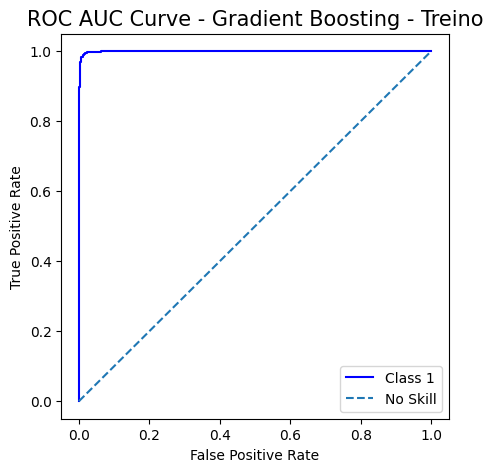

In [52]:
# plota a curva ROC de teste
plot_roc_curve(Y_train, Y_pred_proba_train, 'Gradient Boosting - Treino')

<AxesSubplot:xlabel='Churn_Prob', ylabel='Count'>

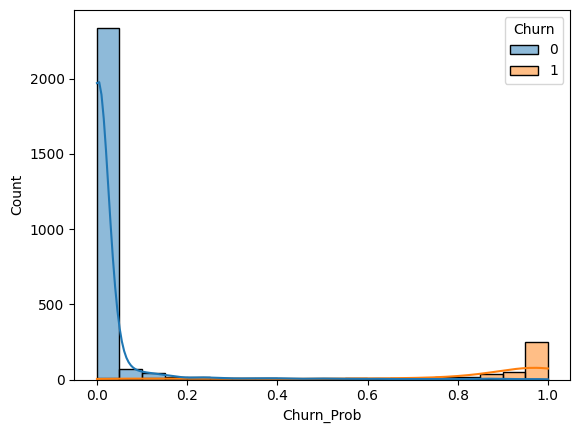

In [53]:
# plota um histograma com as probabilidades de churn
df_result = pd.DataFrame({'Churn':Y_test, 'Churn_Prob':Y_pred_proba})
sns.histplot(data=df_result,x = 'Churn_Prob',hue='Churn', bins=20, kde=True)

<AxesSubplot:xlabel='Churn_Prob', ylabel='Count'>

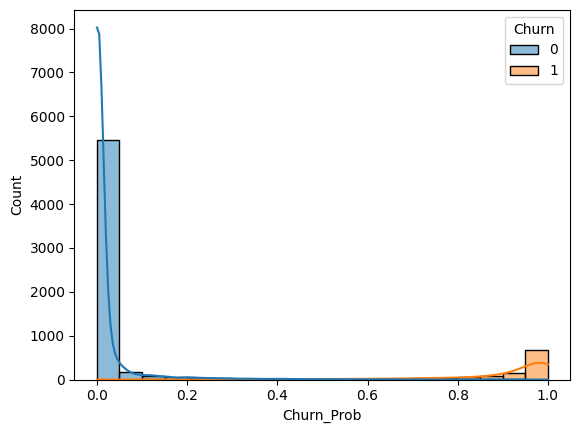

In [54]:
# plota um histograma com as probabilidades de churn
df_result = pd.DataFrame({'Churn':Y_train, 'Churn_Prob':Y_pred_proba_train})
sns.histplot(data=df_result,x = 'Churn_Prob',hue='Churn', bins=20, kde=True)

##### 4.1.2 Regressão Logística

In [55]:
# define os hiperparametros
parametros = {
        'penalty': ['l1','l2','elasticnet'],
        'C': [1,0.5,0.1],
        'max_iter': [5000, 10000, 20000]
        }


# define o modelo
modelo_rl = LogisticRegression()

# define a estratégia de busca
grid_rl = GridSearchCV(modelo_rl, parametros, cv=5, scoring='roc_auc', n_jobs=-1)

# treina o modelo
grid_rl.fit(X_train, Y_train)

c:\Users\otavi\OneDrive\Documents\UFABC\2023-01\Aprendizado de Máquina\Projeto\projeto\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\otavi\OneDrive\Documents\UFABC\2023-01\Aprendizado de Máquina\Projeto\projeto\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\otavi\OneDrive\Documents\UFABC\2023-01\Aprendizado de Máquina\Projeto\projeto\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _chec

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 0.5, 0.1], 'max_iter': [5000, 10000, 20000],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='roc_auc')

In [56]:
# imprime os melhores parâmetros
print(f'Os melhores parâmetros encontrados foram: {grid_rl.best_params_}')

# coloca os resultados em um dataframe
resultados = pd.DataFrame(grid_rl.cv_results_)
resultados = resultados.sort_values('mean_test_score', ascending=False)
resultados.head()

Os melhores parâmetros encontrados foram: {'C': 0.5, 'max_iter': 5000, 'penalty': 'l2'}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,1.706442,0.736118,0.005670,0.000894,0.5,5000,l2,"{'C': 0.5, 'max_iter': 5000, 'penalty': 'l2'}",0.921098,0.910726,0.925376,0.908679,0.919267,0.917029,0.006336,1
13,1.544374,0.700593,0.006141,0.002334,0.5,10000,l2,"{'C': 0.5, 'max_iter': 10000, 'penalty': 'l2'}",0.921098,0.910726,0.925376,0.908679,0.919267,0.917029,0.006336,1
16,1.493543,0.633315,0.007885,0.004400,0.5,20000,l2,"{'C': 0.5, 'max_iter': 20000, 'penalty': 'l2'}",0.921098,0.910726,0.925376,0.908679,0.919267,0.917029,0.006336,1
19,1.103917,0.289987,0.005982,0.001953,0.1,5000,l2,"{'C': 0.1, 'max_iter': 5000, 'penalty': 'l2'}",0.921138,0.910479,0.925525,0.910039,0.917743,0.916985,0.006022,4
22,1.151928,0.384342,0.009772,0.006149,0.1,10000,l2,"{'C': 0.1, 'max_iter': 10000, 'penalty': 'l2'}",0.921138,0.910479,0.925525,0.910039,0.917743,0.916985,0.006022,4


In [57]:
# treina o modelo com os melhores parâmetros
modelo_rl = LogisticRegression(
    C=grid_rl.best_params_['C'],
    max_iter=grid_rl.best_params_['max_iter'],
    penalty=grid_rl.best_params_['penalty']
)

# treina o modelo
modelo_rl.fit(X_train, Y_train)

# faz as previsões com dados de teste
Y_pred = modelo_rl.predict(X_test)
Y_pred_proba = modelo_rl.predict_proba(X_test)[:, 1]

# faz as previsões com dados de treino
Y_pred_train = modelo_rl.predict(X_train)
Y_pred_proba_train = modelo_rl.predict_proba(X_train)[:, 1]

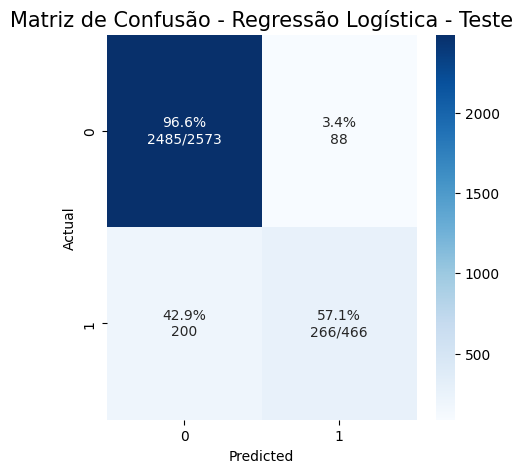

Predicted,0,1
Actual,,
0,2485,88
1,200,266


In [58]:
# plota a matriz de confusão de teste
plot_cm(Y_test, Y_pred, 'Regressão Logística - Teste')

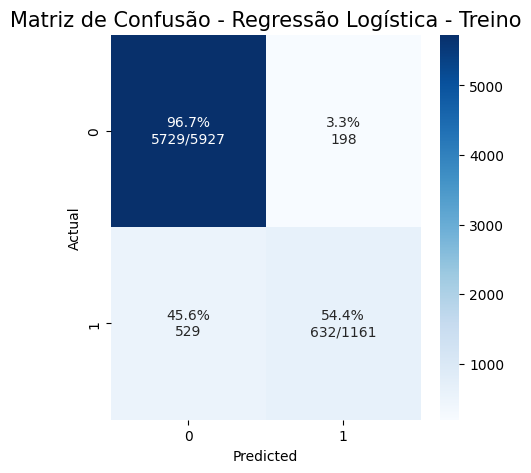

Predicted,0,1
Actual,,
0,5729,198
1,529,632


In [59]:
# plota a matriz de confusão de teste
plot_cm(Y_train, Y_pred_train, 'Regressão Logística - Treino')

No Skill: ROC AUC=0.500
Regressão Logística - Teste: ROC AUC=0.919


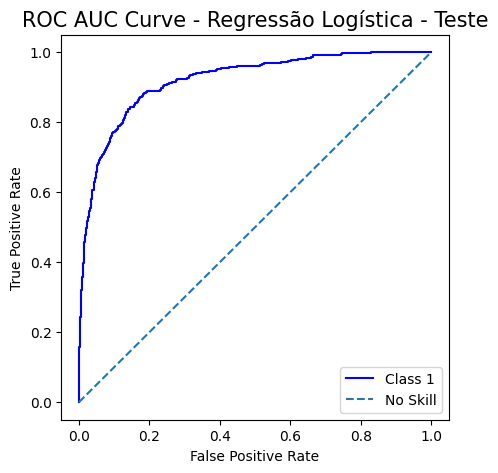

In [60]:
# plota a curva ROC de teste
plot_roc_curve(Y_test, Y_pred_proba, 'Regressão Logística - Teste')

No Skill: ROC AUC=0.500
Regressão Logística - Treino: ROC AUC=0.918


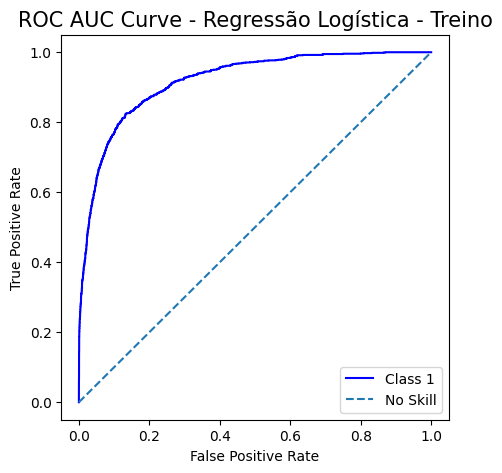

In [61]:
# plota a curva ROC de teste
plot_roc_curve(Y_train, Y_pred_proba_train, 'Regressão Logística - Treino')

<AxesSubplot:xlabel='Churn_Prob', ylabel='Count'>

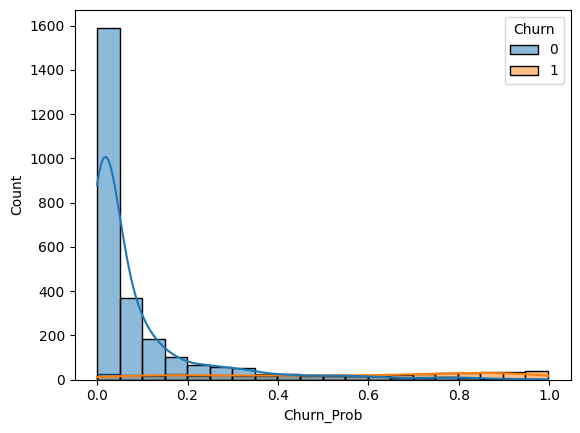

In [62]:
# plota um histograma com as probabilidades de churn
df_result = pd.DataFrame({'Churn':Y_test, 'Churn_Prob':Y_pred_proba})
sns.histplot(data=df_result,x = 'Churn_Prob',hue='Churn', bins=20, kde=True)

<AxesSubplot:xlabel='Churn_Prob', ylabel='Count'>

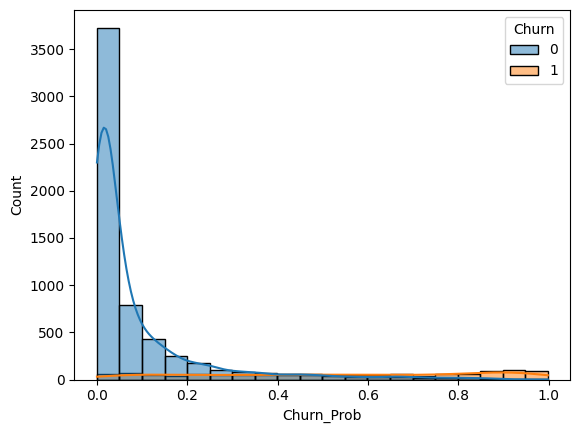

In [63]:
# plota um histograma com as probabilidades de churn
df_result = pd.DataFrame({'Churn':Y_train, 'Churn_Prob':Y_pred_proba_train})
sns.histplot(data=df_result,x = 'Churn_Prob',hue='Churn', bins=20, kde=True)

#### 4.2 Encontrando o Melhor Threshold

##### 4.2.1 Gradient Boosting

In [64]:
# faz as previsões com dados de teste
Y_pred = modelo_gb.predict(X_test)
Y_pred_proba = modelo_gb.predict_proba(X_test)[:, 1]

# faz as previsões com dados de treino
Y_pred_train = modelo_gb.predict(X_train)
Y_pred_proba_train = modelo_gb.predict_proba(X_train)[:, 1]

In [65]:
# inicializa a lista de scores
score = []
max_score = 0
dif_minima = 1

# loop para testar diferentes thresholds
for threshold in np.arange(0.1, 0.9, 0.01):
    # aplica o threshold na probabilidade
    Y_pred_treshold = (Y_pred_proba > threshold).astype(int)

    # calcula as métricas
    vlr_f1_score = f1_score(Y_test, Y_pred_treshold)
    vlr_recall_score = recall_score(Y_test, Y_pred_treshold)
    vlr_precision_score = precision_score(Y_test, Y_pred_treshold)

    # mínimo entre recall e precision
    vlr_min_score = abs(vlr_recall_score - vlr_precision_score)
    if vlr_min_score < dif_minima:
        dif_minima = vlr_min_score
        best_min_threshold = threshold

    # salva o threshold e o score se ele for maior que o máximo
    if vlr_f1_score > max_score:
        max_score = vlr_f1_score
        best_f1_threshold = threshold

    # adiciona o resultado na lista
    score.append((threshold,vlr_f1_score,vlr_recall_score,vlr_precision_score))
print(f'O F1-Score máximo foi de {max_score:.2f} usando o threshold de {best_f1_threshold:.2f}')
print(f'A menor diferença entre precision e recall foi de {dif_minima:.2f} usando o threshold de {best_min_threshold:.2f}')

# threshold final do modelo de boosting
threshold_gb = best_min_threshold

O F1-Score máximo foi de 0.89 usando o threshold de 0.47
A menor diferença entre precision e recall foi de 0.00 usando o threshold de 0.43


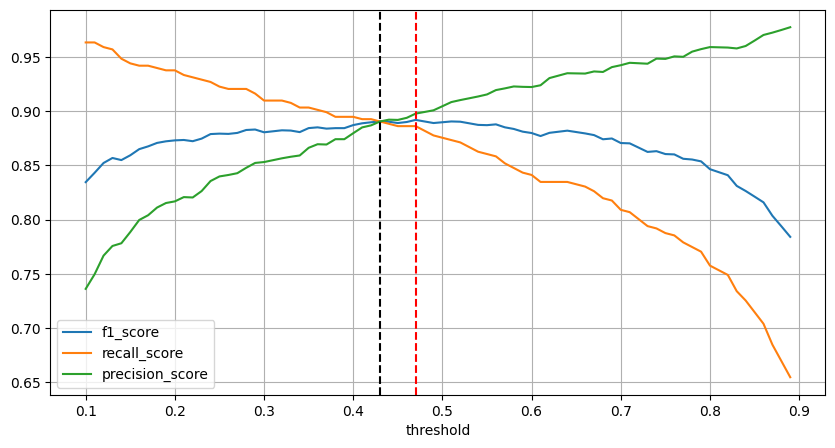

In [66]:
# plotando o gráfico de F1-Score
df_score = pd.DataFrame(score, columns=['threshold','f1_score','recall_score','precision_score'])
ax = df_score.plot(x='threshold', y=['f1_score','recall_score','precision_score'], figsize=(10,5), grid=True)
ax.axvline(best_f1_threshold, color="red", linestyle="--",label='Melhor F1')
ax.axvline(best_min_threshold, color="black", linestyle="--",label='Precision = Recall')

##### 4.2.2 Regressão Logística

In [67]:
# faz as previsões com dados de teste
Y_pred = modelo_rl.predict(X_test)
Y_pred_proba = modelo_rl.predict_proba(X_test)[:, 1]

# faz as previsões com dados de treino
Y_pred_train = modelo_rl.predict(X_train)
Y_pred_proba_train = modelo_rl.predict_proba(X_train)[:, 1]

In [68]:
# inicializa a lista de scores
score = []
max_score = 0
dif_minima = 1

# loop para testar diferentes thresholds
for threshold in np.arange(0.1, 0.9, 0.01):
    # aplica o threshold na probabilidade
    Y_pred_treshold = (Y_pred_proba > threshold).astype(int)

    # calcula as métricas
    vlr_f1_score = f1_score(Y_test, Y_pred_treshold)
    vlr_recall_score = recall_score(Y_test, Y_pred_treshold)
    vlr_precision_score = precision_score(Y_test, Y_pred_treshold)

    # mínimo entre recall e precision
    vlr_min_score = abs(vlr_recall_score - vlr_precision_score)
    if vlr_min_score < dif_minima:
        dif_minima = vlr_min_score
        best_min_threshold = threshold

    # salva o threshold e o score se ele for maior que o máximo
    if vlr_f1_score > max_score:
        max_score = vlr_f1_score
        best_f1_threshold = threshold

    # adiciona o resultado na lista
    score.append((threshold,vlr_f1_score,vlr_recall_score,vlr_precision_score))
print(f'O F1-Score máximo foi de {max_score:.2f} usando o threshold de {best_f1_threshold:.2f}')
print(f'A menor diferença entre precision e recall foi de {dif_minima:.2f} usando o threshold de {best_min_threshold:.2f}')

# threshold final do modelo de regressão
threshold_rl = best_min_threshold

O F1-Score máximo foi de 0.69 usando o threshold de 0.38
A menor diferença entre precision e recall foi de 0.00 usando o threshold de 0.36


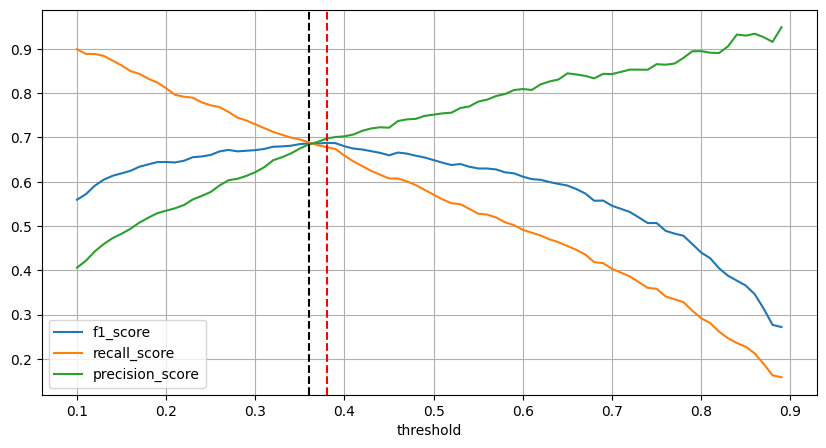

In [69]:
# plotando o gráfico de F1-Score
df_score = pd.DataFrame(score, columns=['threshold','f1_score','recall_score','precision_score'])
ax = df_score.plot(x='threshold', y=['f1_score','recall_score','precision_score'], figsize=(10,5), grid=True)
ax.axvline(best_f1_threshold, color="red", linestyle="--",label='Melhor F1')
ax.axvline(best_min_threshold, color="black", linestyle="--",label='Precision = Recall')

### 4.3 Fazendo Previsões e métricas finais

##### 4.3.1 Gradient Boosting

In [70]:
# faz as previsões com dados de teste
Y_pred = modelo_gb.predict(X_test)
Y_pred_proba = modelo_gb.predict_proba(X_test)[:, 1]

# faz as previsões com dados de treino
Y_pred_train = modelo_gb.predict(X_train)
Y_pred_proba_train = modelo_gb.predict_proba(X_train)[:, 1]

# aplica o threshold na probabilidade
Y_pred_treshold = (Y_pred_proba > threshold_gb).astype(int)

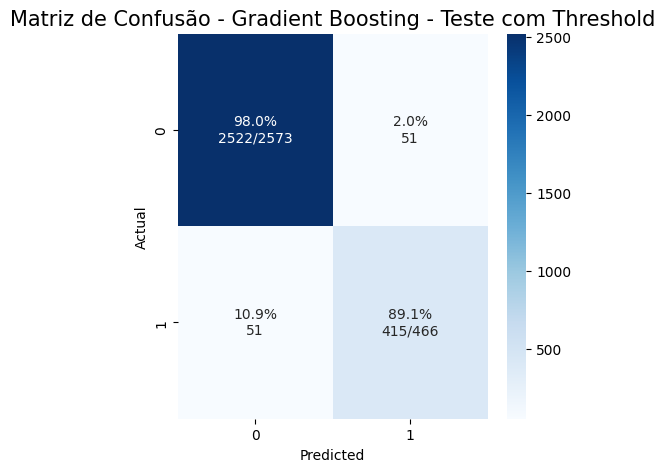

Predicted,0,1
Actual,,
0,2522,51
1,51,415


In [71]:
# plota a matriz de confusão de teste
plot_cm(Y_test, Y_pred_treshold, 'Gradient Boosting - Teste com Threshold')

No Skill: ROC AUC=0.500
Gradient Boosting - Teste com Threshold: ROC AUC=0.990


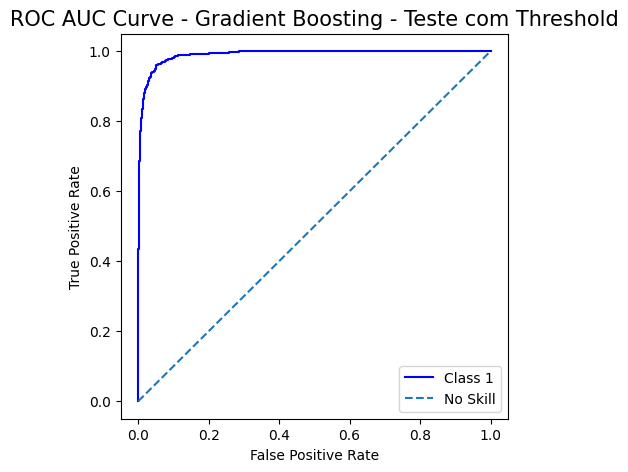

In [72]:
# plota a curva ROC de teste
plot_roc_curve(Y_test, Y_pred_proba, 'Gradient Boosting - Teste com Threshold')

<AxesSubplot:xlabel='Churn_Prob', ylabel='Count'>

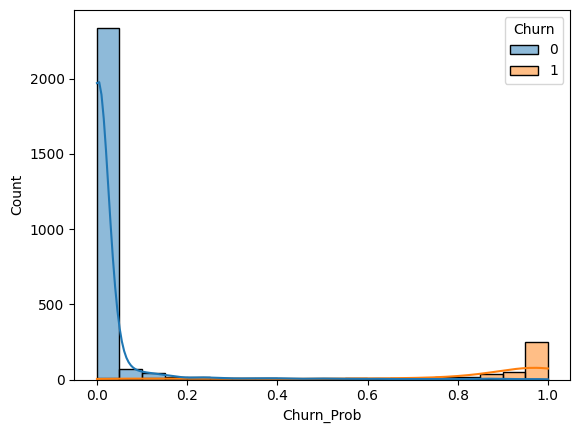

In [73]:
# plota um histograma com as probabilidades de churn
df_result = pd.DataFrame({'Churn':Y_test, 'Churn_Prob':Y_pred_proba})
sns.histplot(data=df_result,x = 'Churn_Prob',hue='Churn', bins=20, kde=True)

##### 4.3.2 Regressão Logística

In [74]:
# faz as previsões com dados de teste
Y_pred = modelo_rl.predict(X_test)
Y_pred_proba = modelo_rl.predict_proba(X_test)[:, 1]

# faz as previsões com dados de treino
Y_pred_train = modelo_rl.predict(X_train)
Y_pred_proba_train = modelo_rl.predict_proba(X_train)[:, 1]

# aplica o threshold na probabilidade
Y_pred_treshold = (Y_pred_proba > threshold_rl).astype(int)

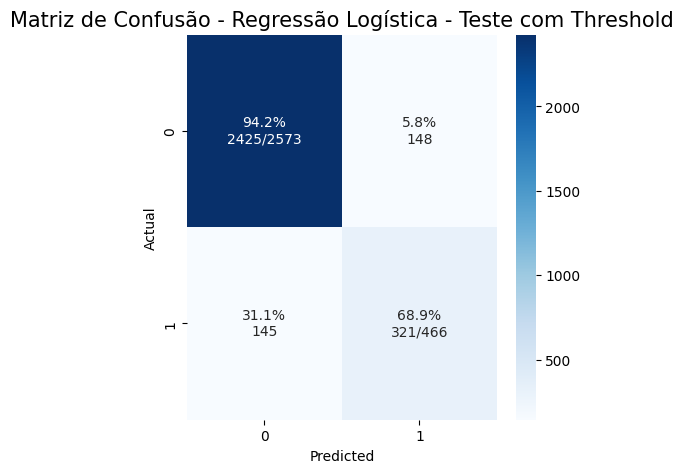

Predicted,0,1
Actual,,
0,2425,148
1,145,321


In [75]:
# plota a matriz de confusão de teste
plot_cm(Y_test, Y_pred_treshold, 'Regressão Logística - Teste com Threshold')

No Skill: ROC AUC=0.500
Regressão Logística - Teste com Threshold: ROC AUC=0.919


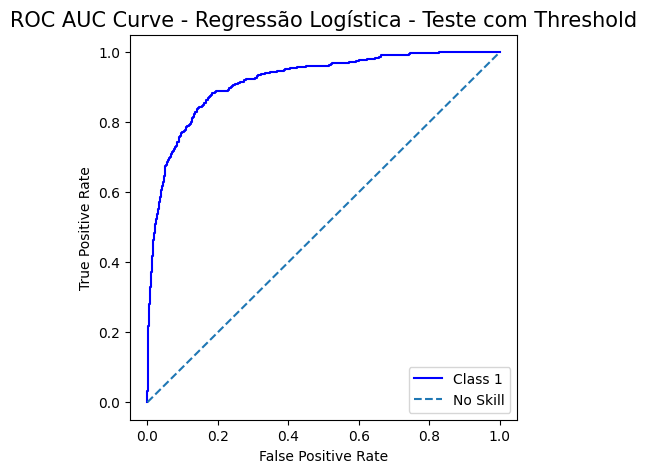

In [76]:
# plota a curva ROC de teste
plot_roc_curve(Y_test, Y_pred_proba, 'Regressão Logística - Teste com Threshold')

<AxesSubplot:xlabel='Churn_Prob', ylabel='Count'>

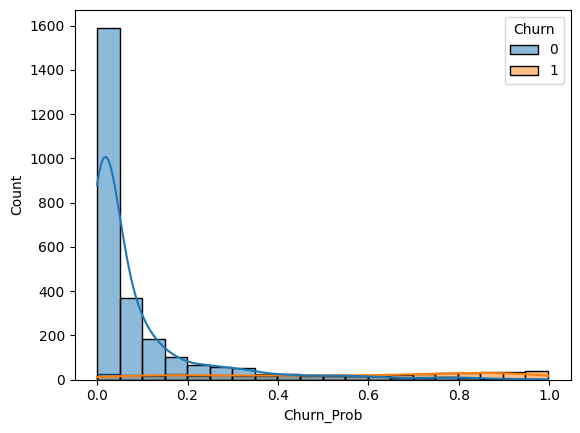

In [77]:
# plota um histograma com as probabilidades de churn
df_result = pd.DataFrame({'Churn':Y_test, 'Churn_Prob':Y_pred_proba})
sns.histplot(data=df_result,x = 'Churn_Prob',hue='Churn', bins=20, kde=True)